## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [2]:
import numpy as np
import glob
import warnings
import scipy as sp
import scipy.io
import scipy.signal
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

% matplotlib inline
plt.style.use('ggplot')


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


In [3]:
data_fls, ref_fls = LoadTroikaDataset()

In [4]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [5]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

In [6]:
def BandpassFilter(sig, freq_filter=(40 / 60, 240 / 60), fs=125):
    """Bandpass Filter.

    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band
        Frequency components outside two elements in the tuple will be removed
        fs: (number) The sampling rate of <signal>

    Returns:
        (np.array) The filtered signal
    """
    b, a = scipy.signal.butter(3, freq_filter, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, sig)


def PlotSpectrogram(sig, fs):
    """
    Plots Spectogram
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Plot
    """
    fig = plt.figure(figsize=(8, 5))
    plt.specgram(sig, Fs=fs, NFFT=250,
                 noverlap=125, xextent=[0, len(sig) / fs / 60]);
    plt.xlabel('Time (min)')
    plt.ylabel('Frequency (Hz)')


def PlotFilteredSpectogram(sig):
    """
    Plots Spectogram
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Plot

    """
    fig = plt.figure(figsize=(8, 5))
    filtered_sig = BandpassFilter(sig)
    plt.specgram(filtered_sig, Fs=fs, NFFT=250,
                 noverlap=125, xextent=[0, len(sig) / fs / 60]);
    plt.xlabel('Time (min)')
    plt.ylabel('Frequency (Hz)')


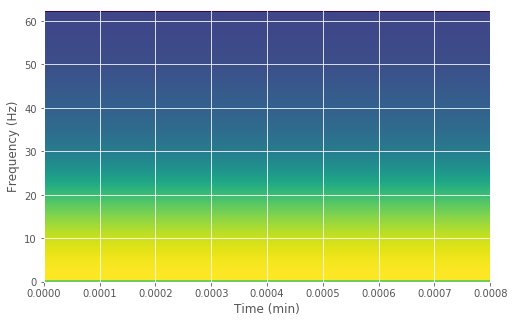

In [7]:
fs = 125
freq_filter=(40/60.0, 240/60.0)

PlotSpectrogram(sp.io.loadmat(data_fls[0])['sig'], fs)
    

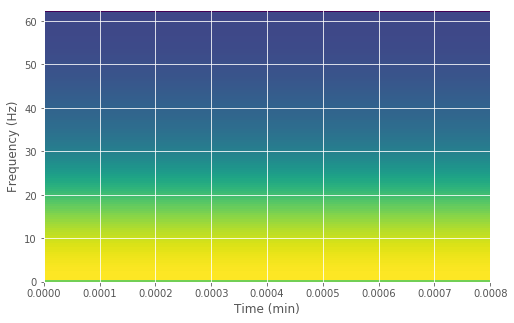

In [8]:
PlotFilteredSpectogram(sp.io.loadmat(data_fls[0])['sig'])

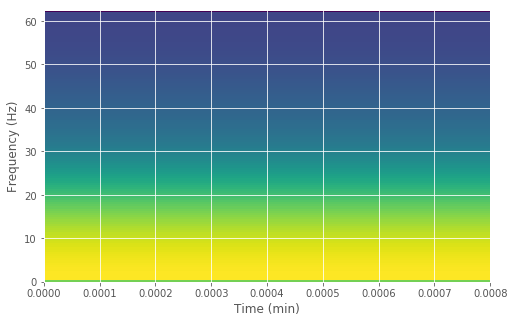

In [9]:
PlotSpectrogram(sp.io.loadmat(data_fls[6])['sig'], fs)

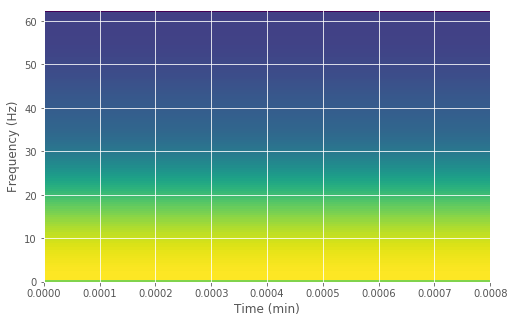

In [10]:
PlotFilteredSpectogram(sp.io.loadmat(data_fls[6])['sig'])

In [11]:
data_fl, ref_fl = data_fls[0], ref_fls[0]
bpm = sp.io.loadmat(ref_fl)['BPM0']
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ppg = BandpassFilter(ppg)
accx = BandpassFilter(accx)
accy = BandpassFilter(accy)
accz = BandpassFilter(accz)
acc = np.sqrt(accx**2 + accy**2 + accz**2)
acc

array([ 0.02203684,  0.02803522,  0.03435165, ...,  0.01121658,
        0.0104505 ,  0.00960517])

In [12]:
def FourierTransform(signal, fs):
    """
    Discrete Fourier Transform on a signal
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Freq and Magnitude of the signal
    """
    freqs = np.fft.rfftfreq(6 * len(signal), 1 / fs)
    fft = np.abs(np.fft.rfft(signal, 6 * len(signal)))
    return freqs, fft


def Plotfft(signal, freqs, fft, fs):
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
    ts = np.arange(len(signal)) / fs
    plt.plot(ts, signal)
    plt.subplot(2, 1, 2)
    plt.plot(freqs, np.abs(fft))
    plt.title("freq domain")
    plt.xlabel("freq")
    plt.tight_layout()


In [13]:
ppg_window = ppg[0:8*fs]
acc_window = acc[0:8*fs]
ppg_freqs, ppg_fft = FourierTransform(ppg_window, fs)

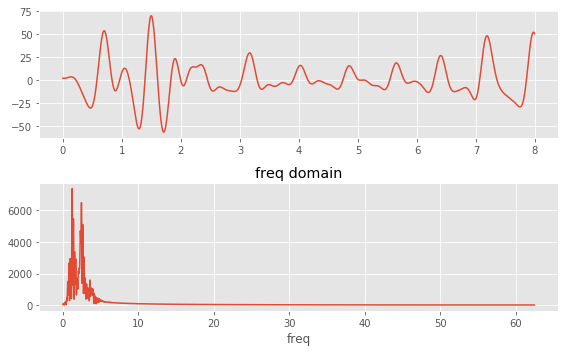

In [14]:
Plotfft(ppg_window, ppg_freqs, ppg_fft, fs)

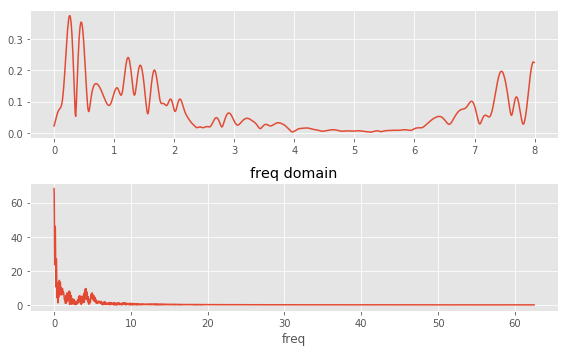

In [15]:
acc_freqs, acc_fft = FourierTransform(acc_window, fs)
Plotfft(acc_window, acc_freqs, acc_fft, fs)


#### Find Peaks

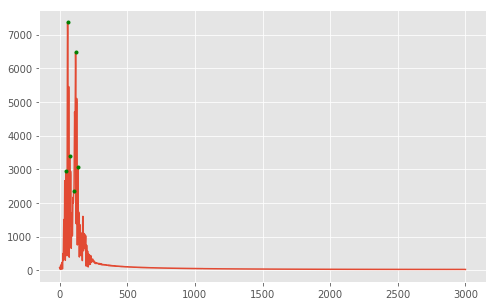

In [16]:
peaks_ppg = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
fig= plt.figure(figsize=(8,5))
plt.plot(ppg_fft)
plt.plot(peaks_ppg, ppg_fft[peaks_ppg], 'g.');

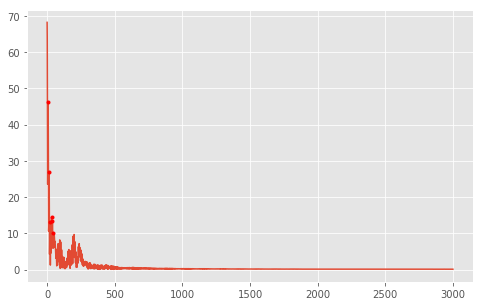

In [17]:
peaks_acc = sp.signal.find_peaks(acc_fft, height=10)[0]
fig= plt.figure(figsize=(8,5))
plt.plot(acc_fft)
plt.plot(peaks_acc, acc_fft[peaks_acc], 'r.');

In [18]:
accx_window = accx[0:8*fs]
accy_window = accy[0:8*fs]
accz_window = accz[0:8*fs]

In [19]:
accx_freqs, accx_fft = FourierTransform(accx_window, fs)
accy_freqs, accy_fft = FourierTransform(accy_window, fs)
accz_freqs, accz_fft = FourierTransform(accz_window, fs)

[ 0.66666667  0.83333333  0.97916667  1.125     ]
[ 0.77083333  1.79166667  1.9375      2.10416667]
[ 0.66666667  0.8125      0.97916667  1.25        1.39583333  1.54166667
  1.66666667  1.8125      2.20833333  2.35416667  2.47916667  2.625
  2.77083333]


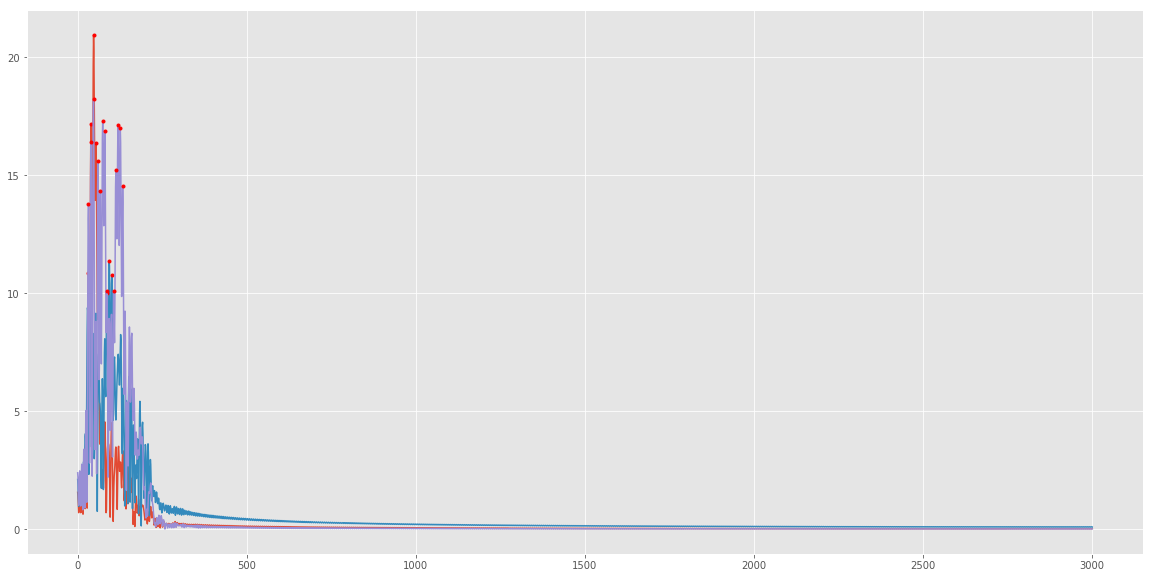

In [20]:
peaks_accx = sp.signal.find_peaks(accx_fft, height=10)[0]
fig= plt.figure(figsize=(20,10))
plt.plot(accx_fft)
plt.plot(peaks_accx, accx_fft[peaks_accx], 'r.')
print(accx_freqs[peaks_accx])

peaks_accy = sp.signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(peaks_accy, accy_fft[peaks_accy], 'r.')
print(accy_freqs[peaks_accy])

peaks_accz = sp.signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(peaks_accz, accz_fft[peaks_accz], 'r.')
print(accz_freqs[peaks_accz])

### Metrics

In [21]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


In [22]:
def CreateFeatures(ppg, accx, accy, accz, fs=125):
    """
    Create features from the data

    Args:
        ppg: (np.array) The input signal
        accx
        accy
        accz
        fs: (number) The sampling rate of <signal>

    Returns:
        PPG and ACC features
    """

    # Filter data
    ppg_freqs, ppg_fft = FourierTransform(ppg, fs)
    ppg_fft[ppg_freqs <= 40 / 60] = 0.0
    ppg_fft[ppg_freqs >= 240 / 60] = 0.0

    acc = np.sqrt(accx ** 2 + accy ** 2 + accz ** 2)

    # FFT for acc
    acc_freqs, acc_fft = FourierTransform(acc, fs)
    acc_fft[acc_freqs <= 40 / 60] = 0.0
    acc_fft[acc_freqs >= 240 / 60] = 0.0

    # max freq for ppg
    ppg_feature = ppg_freqs[np.argmax(ppg_fft)]

    # max freq for acc
    acc_feature = acc_freqs[np.argmax(acc_fft)]

    # The mean of each channel
    mn_x = np.mean(accx)
    mn_y = np.mean(accy)
    mn_z = np.mean(accz)

    # The standard deviation of each channel
    std_x = np.std(accx)
    std_y = np.std(accy)
    std_z = np.std(accz)

    # Various percentile values for each channel
    p5_x = np.percentile(accx, 5)
    p5_y = np.percentile(accy, 5)
    p5_z = np.percentile(accz, 5)
    p10_x = np.percentile(accx, 10)
    p10_y = np.percentile(accy, 10)
    p10_z = np.percentile(accz, 10)
    p25_x = np.percentile(accx, 25)
    p25_y = np.percentile(accy, 25)
    p25_z = np.percentile(accz, 25)
    p50_x = np.percentile(accx, 50)
    p50_y = np.percentile(accy, 50)
    p50_z = np.percentile(accz, 50)
    p90_x = np.percentile(accx, 90)
    p90_y = np.percentile(accy, 90)
    p90_z = np.percentile(accz, 90)
    return np.array([ppg_feature, acc_feature, mn_x, mn_y,
                     mn_z, std_x, std_y, std_z, p5_x, p5_y, p5_z, p10_x, p10_y, p10_z
                        , p25_x, p25_y, p25_z, p50_x, p50_y, p50_z, p90_x, p90_y, p90_z])


In [23]:
CreateFeatures(ppg, accx, accy, accz, fs = 125)

array([  2.92041191e+00,   2.91931360e+00,   2.97795009e-05,
         1.56882192e-05,  -4.37662948e-05,   4.94873121e-01,
         5.85681315e-01,   6.38801543e-01,  -1.01132598e+00,
        -1.03581435e+00,  -1.28762826e+00,  -7.36608861e-01,
        -7.93157948e-01,  -9.30701120e-01,  -1.82453757e-01,
        -3.05749118e-01,  -2.69127674e-01,   1.73263823e-02,
         2.07283646e-03,   1.44392591e-02,   5.66618496e-01,
         7.94206643e-01,   8.04267509e-01])

In [24]:
def RandomForestRegressorModel():
    """
    Train Regressor model

    Returns:
        Trained model
    """
    fs = 125
    win_length = 8
    win_shift = 2

    # Load filenames through LoadTroikaDataset
    data_fls, ref_fls = LoadTroikaDataset()
    features, labels, signals = [], [], []

    for data_fl, ref_fl in zip(data_fls, ref_fls):
        signal = LoadTroikaDataFile(data_fl)
        ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
        left_s = (np.cumsum(np.ones(min(signal.shape[1],
                                        len(ref))) * fs * win_shift) -
                  fs * win_shift).astype(int)
        right_s = left_s + fs * win_length
        for i in range(len(left_s)):
            left, right = left_s[i], right_s[i]
            ppg = BandpassFilter(signal[0, left:right])
            accx = BandpassFilter(signal[1, left:right])
            accy = BandpassFilter(signal[2, left:right])
            accz = BandpassFilter(signal[3, left:right])

            features.append(CreateFeatures(ppg, accx, accy, accz))
            labels.append(ref[i])
            signals.append([ppg, accx, accy, accz])

    features, labels = np.array(features), np.array(labels)
    model = RandomForestRegressor(n_estimators=50,
                                  max_depth=10, random_state=42,
                                  criterion='mae',
                                  min_samples_split=5)
    for train_idx, test_idx in KFold(n_splits=5).split(features, labels):
        X_train, y_train = features[train_idx], labels[train_idx]
        X_test, y_test = features[test_idx], labels[test_idx]
        model.fit(X_train, y_train)

    return model


In [25]:
def ProcessData(data_fl, ref_fl):
    """
    Process Data
    Args:
        data_fl: data files
        ref_fls: refrence files
    Returns:
        features, labels, signals
    """
    # Load data using LoadTroikaDataFile
    signal = LoadTroikaDataFile(data_fl)
    features, labels, signals = [], [], []
    # Load ground truth heart rate
    ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
    fs = 125
    win_length = 8
    win_shift = 2
    left_s = (np.cumsum(np.ones(min(signal.shape[1],
                                    len(ref))) * fs * win_shift) -
              fs * win_shift).astype(int)
    right_s = left_s + fs * win_length
    for i in range(len(left_s)):
        left, right = left_s[i], right_s[i]
        ppg = BandpassFilter(signal[0, left:right])
        accx = BandpassFilter(signal[1, left:right])
        accy = BandpassFilter(signal[2, left:right])
        accz = BandpassFilter(signal[3, left:right])
        features.append(CreateFeatures(ppg, accx, accy, accz))
        labels.append(ref[i])
        signals.append([ppg, accx, accy, accz])
    return features, labels, signals


In [26]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Process Data
    Args:
        data_fl: data files
        ref_fls: refrence files
    Returns:
        errors, confidence
    """
    features, labels, signals = ProcessData(data_fl, ref_fl)
    features, labels = np.array(features), np.array(labels)
    model = RandomForestRegressorModel()

    # Compute pulse rate estimates and estimation confidence.
    errors, confidence = [], []

    for i in range(len(signals)):
        feature, label = features[i], labels[i]
        ppg, accx, accy, accz = signals[i]
        pred = model.predict(np.reshape(feature, (1, -1)))[0]
        ppg = BandpassFilter(ppg)
        accx = BandpassFilter(accx)
        accy = BandpassFilter(accy)
        accz = BandpassFilter(accz)

        freqs = np.fft.rfftfreq(2 * len(ppg), 1 / fs)
        fft = np.abs(np.fft.rfft(ppg, 2 * len(ppg)))
        fft[freqs <= 40 / 60] = 0.0
        fft[freqs >= 240 / 60] = 0.0

        pred_fs = pred / 55
        pred_fs_win = (freqs >= pred_fs - 0.5) & (freqs <= pred_fs + 0.5)
        confid = np.sum(fft[pred_fs_win]) / np.sum(fft)

        errors.append(np.abs(pred - label))
        confidence.append(confid)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence


In [27]:
Evaluate()

5.8633184581211335

-----
### Project Write-up

- **Code Description**

Code estimates pulse rate from the PPG signal and a 3-axis accelerometer signals. It assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.It produces an output at least every 2 seconds.
The code uses TroikaDataset to retrieve a list of .mat files containing reference and signal data. It use scipy.io.loadmat to the .mat file into a python object.

* To execute all code cells in the notebook, click on the Jupyter notebook toolbar or press Ctrl + Shift + Alt + Enter. 
* To run all code cells above the current cell and handle possible code dependencies, click.

- **Data Description** 

Troika dataset is used to validate and test the algorithm. It is recorded from 12 subjects with  age  from  18  to  35 during fast running at the peak speed of 15 km/h. For  each  subject,  the  PPG  signals were  recorded  from  wrist  by  two  pulse  oximeters  with  green  LEDs  (wavelength:  515nm).  Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis  accelerometer.  Both  the  pulse  oximeter  and  the  accelerometer  were  embedded  in  a wristband, which was comfortably worn. The ECG signal is the ground truth as it was recorded simultaneously from the chest using  wet  ECG  sensors.  All  signals  were  sampled  at  125  Hz  and  sent  to  a  nearby  computer  via Bluetooth.  
        

- **Algorithm Description** 

The data is processed using a bandpass filter to make our signal in a reasonable range (40-240 bpm). New features are created e.g.,mean, standard deviation to be used to train a Random Forest Regressor Algorithm. 
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. The algorithm outputs the estimated frequency (in BPM) and the confidence score of that prediction every 2 seconds. Confidence is calculated by totalling the frequency magnitudes near the pulse rate and dividing y the sum of the entire magnitude. The algorithm is likely to fail if the PPG picks a high frequency signal from other movement except heart. The pulsae rate should also not change rapidly in a small time frame. The algorithm is trained on data from 12 people samples, doing similar activities. 
  
- **Algorithm Performance** 

Mean absolute error of the best 90% of the estimates is used to evaluate algorithm performance. We get MAE 5.86 on the train dataset.

The algorithm uses both PPG and accelorometer to estimate signals. The estimates can be distorted by noise from other factors like

* Melanin
* Arm movement
* Arm position
* Finger movement
These noises were removed from the accelrometer. Furthermore, the algorithm is likely to fail if the PPG picks a high frequency signal from other movement except heart. The pulse rate should also not change rapidly in a small time frame. The algorithm is trained on data from 12 people samples, doing similar activities.  These make the algorithm very limited. 
The algorithm outputs absoluter error and confidence. The absolute error is calculate by using reference heart beats which are derived using ECG signals. The confidence is calculated by using signal to noise ratio. The pulse rate is estimated every 2 seconds. It is important to investigate the fundamental assumptions when measuring the algorithm on other dataset.

- **References**

* https://ieeexplore.ieee.org/document/6905737
* https://github.com/t-thanh
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

